In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats
from sklearn import linear_model
from sklearn import tree
# from sklearn.cross_validation import cross_val_score
# from sklearn.metrics import r2_score

In [3]:
# Extending sklearn class to add p and t values to the model.
class LinearRegression(linear_model.LinearRegression):
    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1, get_p_value=True):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        self.t, self.p = 0, 0
        if(get_p_value):
            sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
            se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
            self.t = self.coef_ / se
            self.t = np.round(self.t, 3)
            self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
            self.p = np.round(self.p[0], 3)
        return self

In [4]:
# This method will return the pearson correlation of two lists.
def get_correlation(x, y):
    return np.round(stats.pearsonr(x, y)[0], 3)

In [5]:
def feature_matrix(ds="ml-1M", metric="NDCG100"):
    DS = f"../features_table/{ds}/{metric}.csv"
    return pd.read_csv(DS, sep='\s*,\s*', index_col=0, engine='python')

In [6]:
def plot_heat_map(x_names, y_names, z_values, title):
    df = pd.DataFrame(data=z_values, index=x_names, columns=y_names)
    fig, ax = plt.subplots(figsize=(11, 9))
    sb.heatmap(df)
    plt.show()

In [7]:
def get_x_y_from_pandas(df, features_str, algo):
    X, Y = [], []
    xs = [[] for _ in range(len(features_str))]
    
    for i, f in enumerate(features_str):
        xs[i] = df[[f]].to_numpy().flatten()
    ys = df[[algo]].to_numpy().flatten()
    
    for i in range(len(xs[0])):
        X.append([x[i] for x in xs])
        Y.append(ys[i])
    return np.array(X), np.array(Y)
    

## Variables
Variables that will be usefull on the code.

In [8]:
features_str = [
    "space_size",
    "shape",
    "density",
    "rpu",
    "rpi",
    "gini_u",
    "gini_i",
    "pop_avg",
    "pop_std",
    "pop_skew",
    "pop_kurtosis",
    "long_tail_avg",
    "long_tail_std",
    "long_tail_skew",
    "long_tail_kurtosis"
]

algos = [
    "UserKNN-Amplified",
    "UserKNN-BM25",
    "UserKNN-Cosine",
    "UserKNN-IDF",
    "ItemKNN-AdjustedCosine",
#     "BPR",
#     "MF",
#     "SVD",
#     "PMF",
#     "NMF"
]

df = feature_matrix()

### Independent variables Correlation
This will check how each independent variable is correlated, and aims to drop any redundance that could decrease the regression efficacy.

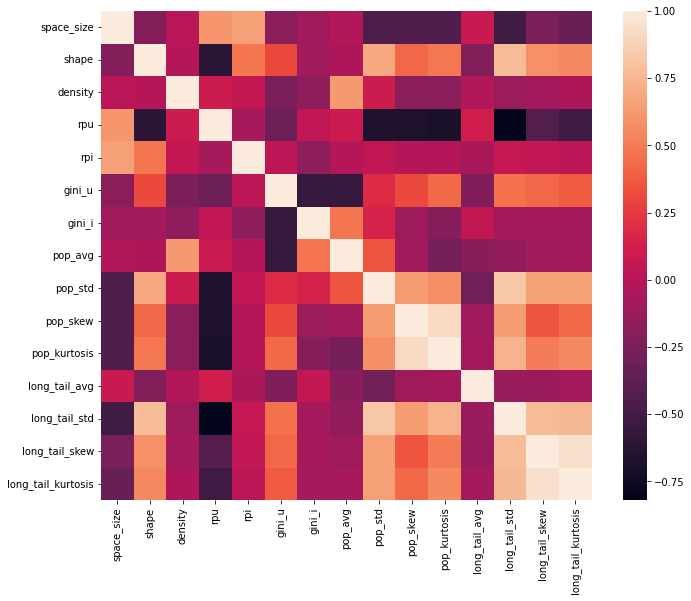

In [9]:
correlations = np.zeros((len(features_str), len(features_str)))
for i, f1 in enumerate(features_str):
    for j, f2 in enumerate(features_str):
        x1, x2 = df[[f1]].to_numpy().flatten(), df[[f2]].to_numpy().flatten()
        correlations.itemset((i, j), get_correlation(x1, x2))
plot_heat_map(features_str, features_str, correlations, "Correlations map")

## Regression Evaluation
Here we start to eval the regression metrics for this model. As done in the article, some of the metrics will be dropped to avoid influence of the correlation showed above.

In [10]:
z = np.zeros((len(features_str)+1, len(algos)))
for i, algo in enumerate(algos):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    model = LinearRegression()
    model.fit(x,y)
    r_sq = np.round(model.score(x, y), 3)
    p_values = model.p
    z.itemset((0, i), r_sq)
    for j in range(len(features_str)):
        z.itemset((j+1, i), p_values.item(j))
ans = pd.DataFrame(data=z, index=["R2"] + features_str, columns=algos)
print(ans)

                    UserKNN-Amplified  UserKNN-BM25  UserKNN-Cosine  \
R2                              0.954         0.964           0.954   
space_size                      0.001         0.430           0.000   
shape                           0.984         0.001           0.739   
density                         0.000         0.000           0.000   
rpu                             0.000         0.000           0.000   
rpi                             0.162         0.000           0.874   
gini_u                          0.000         0.000           0.000   
gini_i                          0.000         0.000           0.000   
pop_avg                         0.000         0.000           0.000   
pop_std                         0.000         0.000           0.000   
pop_skew                        0.000         0.028           0.000   
pop_kurtosis                    0.023         0.150           0.032   
long_tail_avg                   0.000         0.000           0.000   
long_t

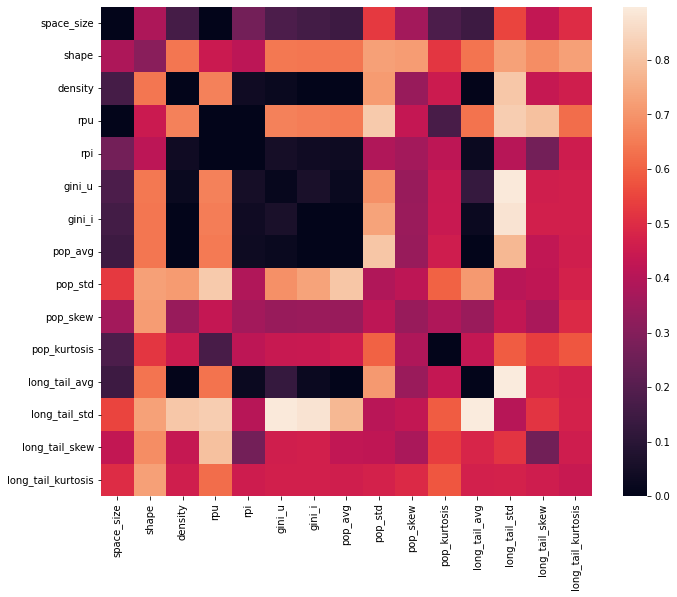

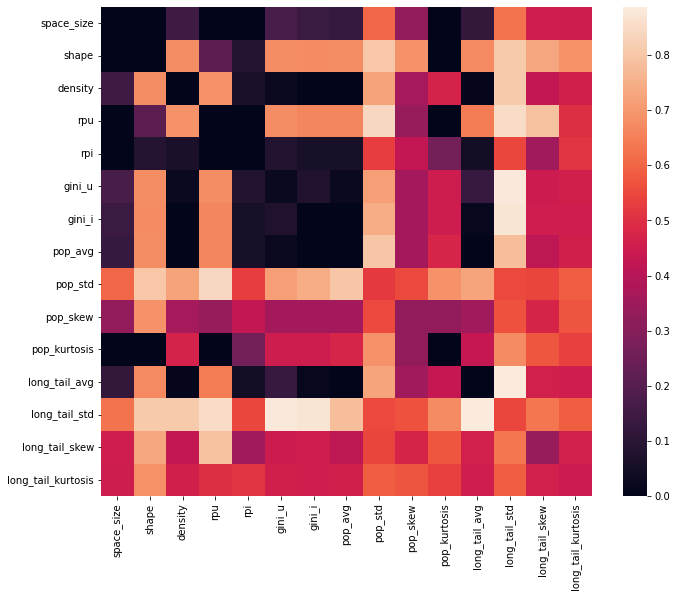

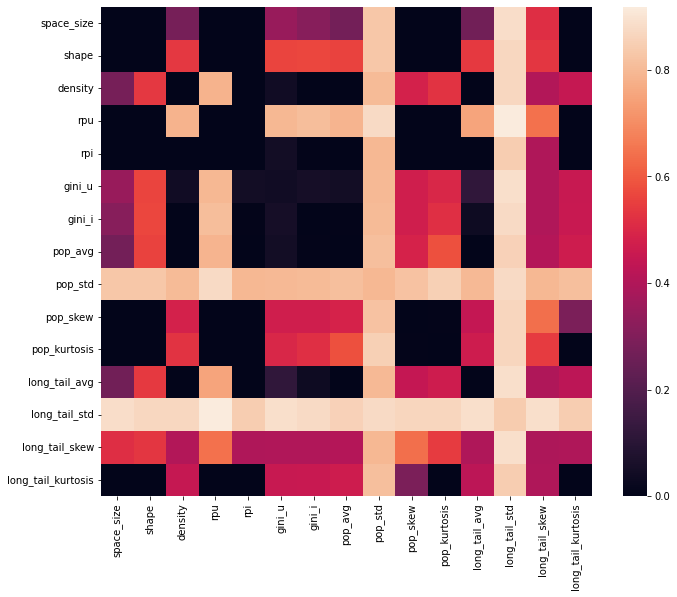

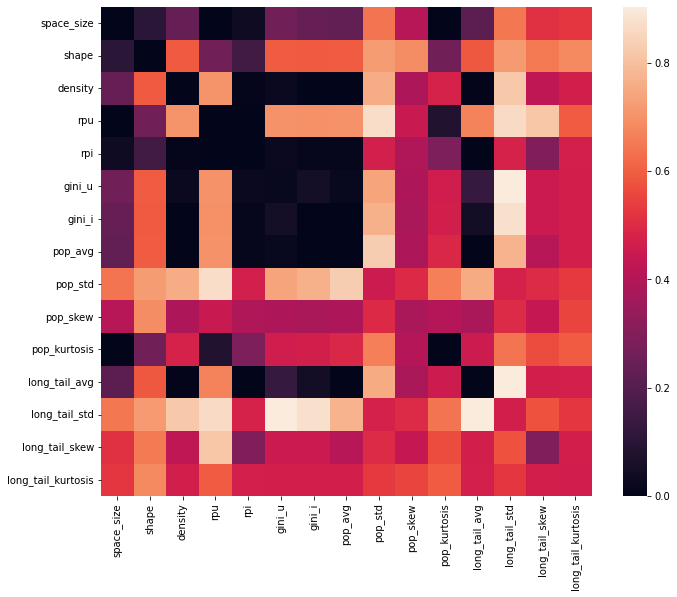

In [11]:
algos_2 = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]
z2 = np.zeros((len(features_str), len(features_str)))

for i, algo in enumerate(algos_2):
    for j, f1 in enumerate(features_str):
        for k, f2 in enumerate(features_str):
            features = [f1, f2]
            x, y = get_x_y_from_pandas(df, features, algo)
            model = LinearRegression()
            model.fit(x,y,get_p_value=False)
            r_sq = np.round(model.score(x, y), 3)
            if(r_sq < 0):
                r_sq = 0.0
            z2.itemset((j, k), r_sq)
    plot_heat_map(features_str, features_str, z2, f"R2 for 2 DCs - {algo}")
    

# Decision Tree!!!!

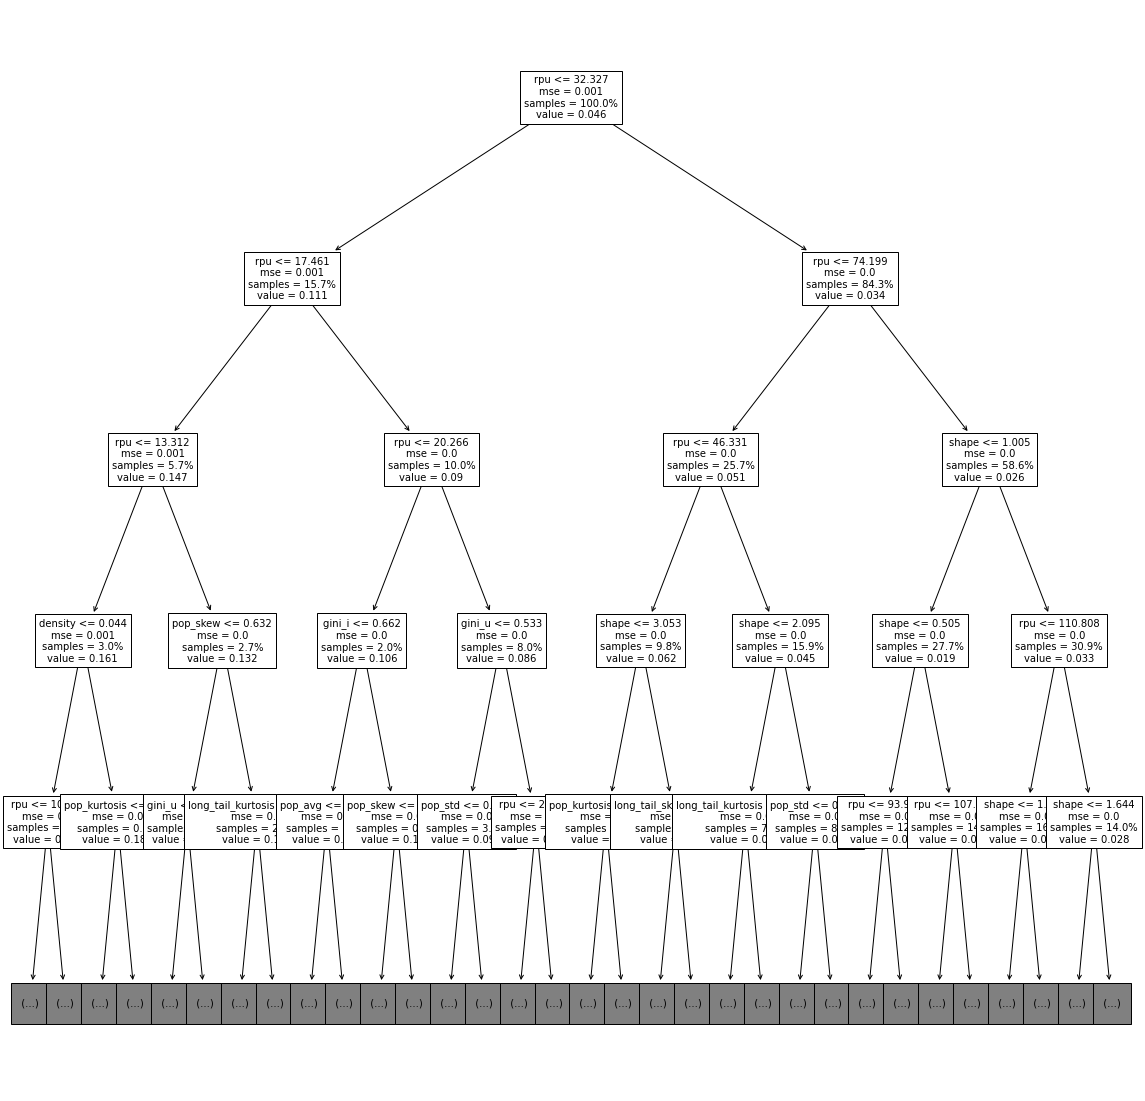

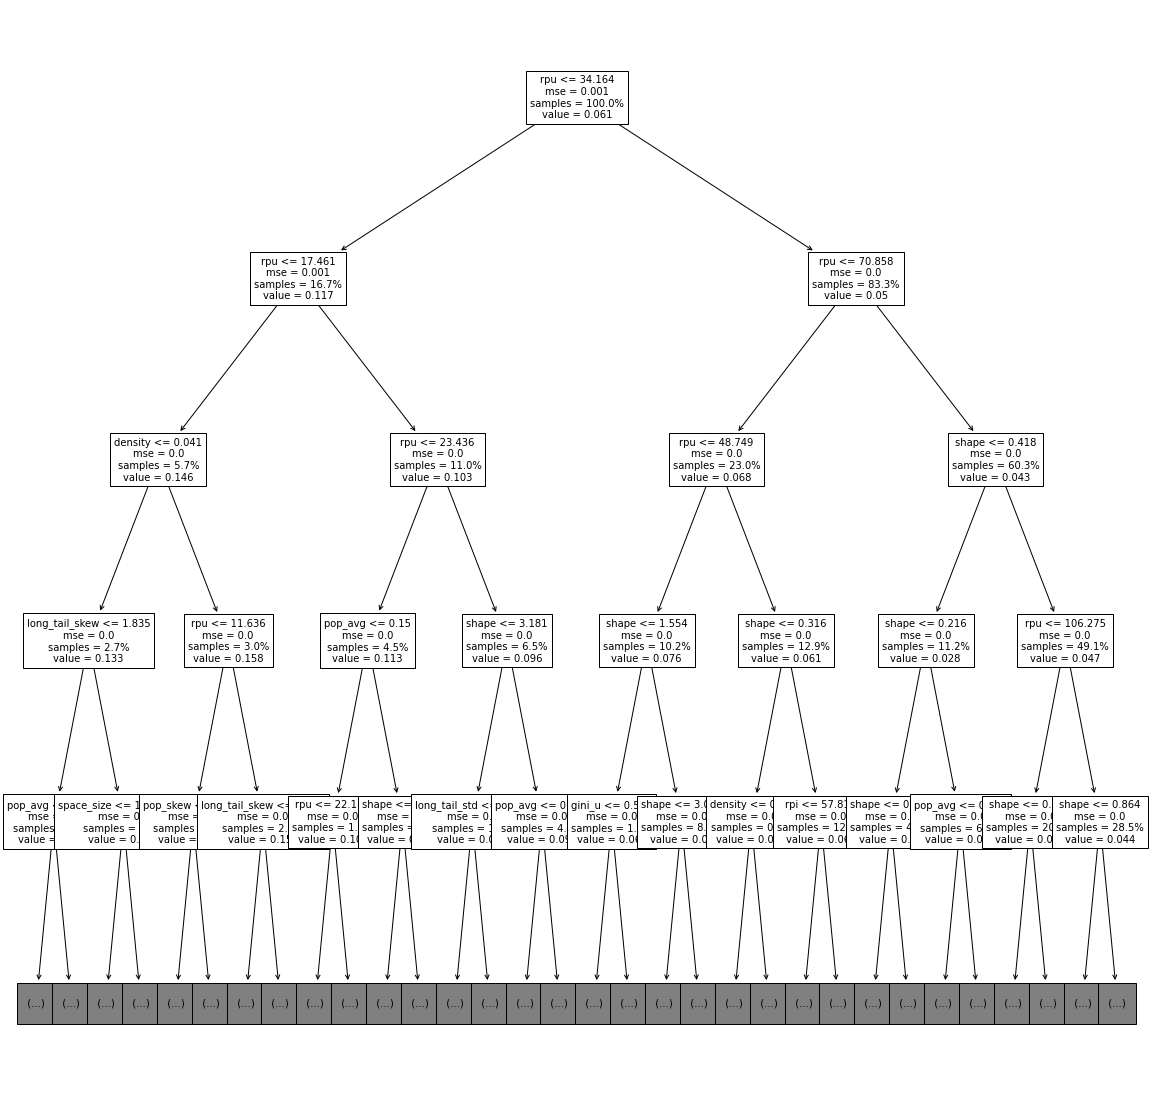

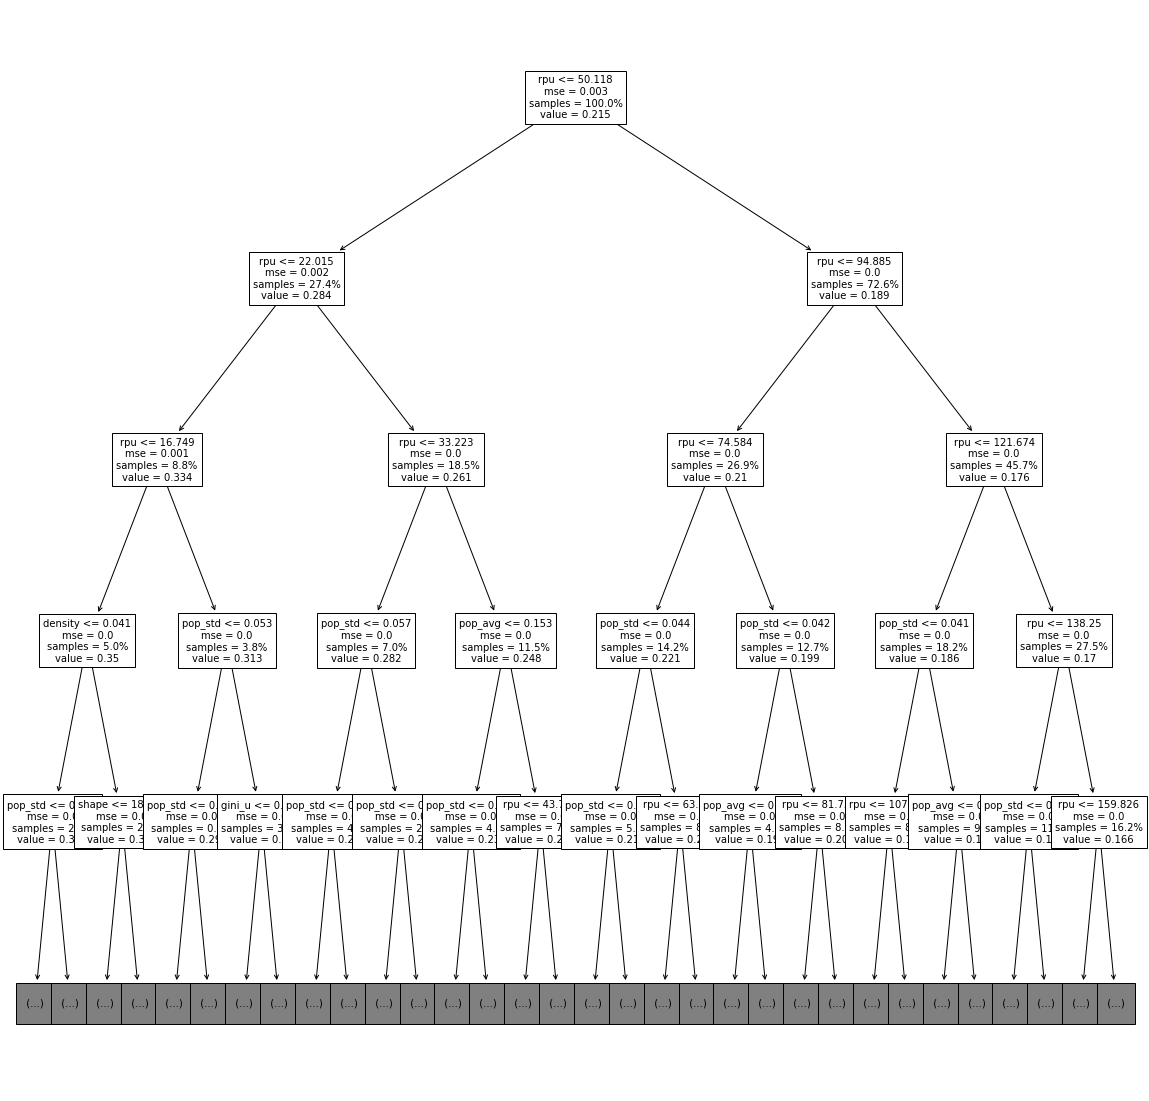

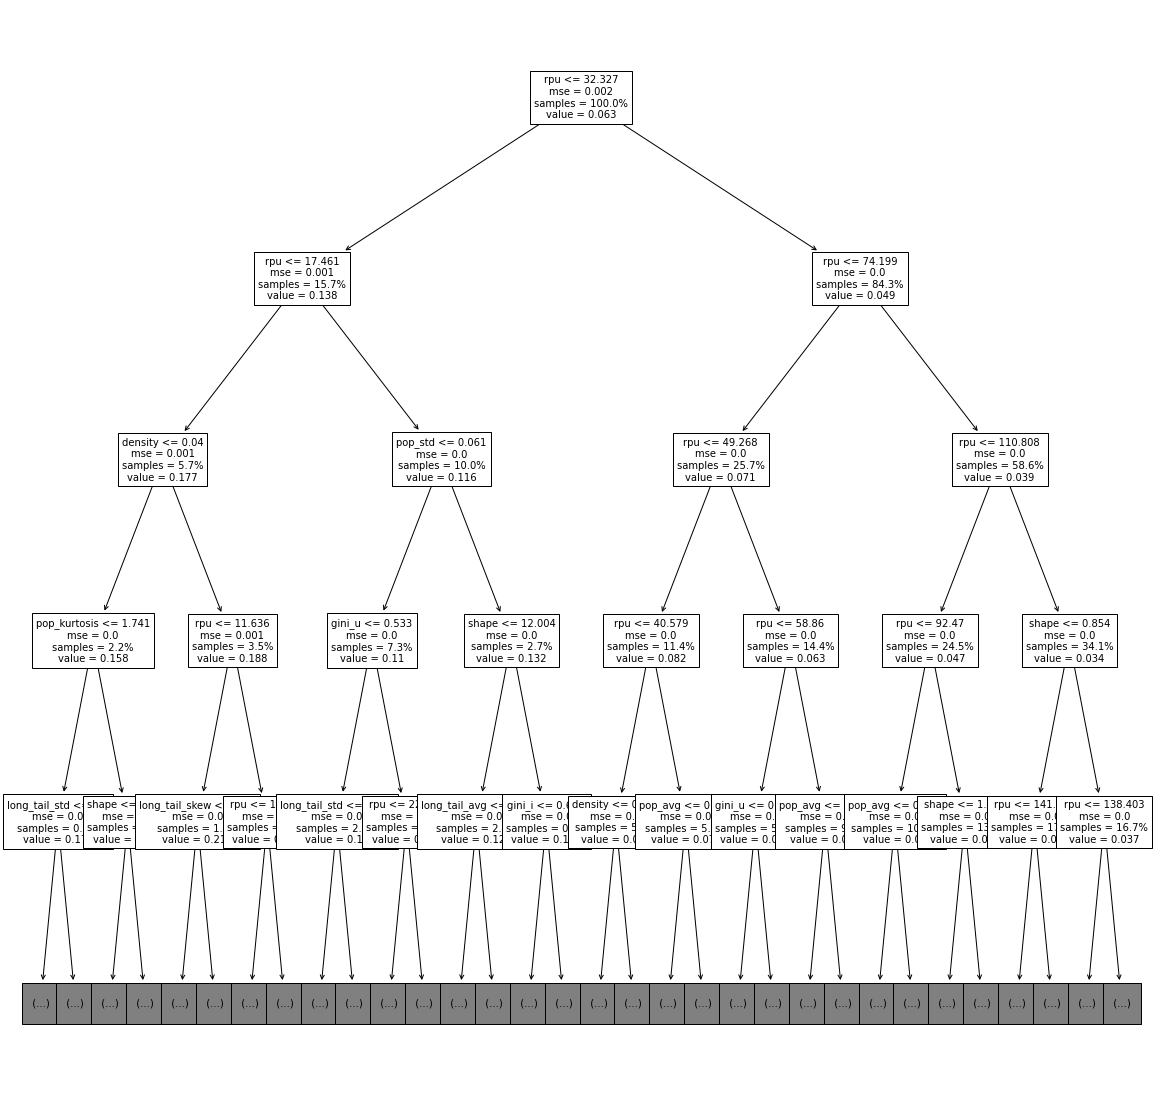

In [12]:
features_str = [
    "space_size",
    "shape",
    "density",
    "rpu",
    "rpi",
    "gini_u",
    "gini_i",
    "pop_avg",
    "pop_std",
    "pop_skew",
    "pop_kurtosis",
    "long_tail_avg",
    "long_tail_std",
    "long_tail_skew",
    "long_tail_kurtosis"
]

# algos = [
#     "UserKNN-Amplified",
#     "UserKNN-BM25",
#     "UserKNN-Cosine",
#     "UserKNN-IDF",
#     "ItemKNN-AdjustedCosine",
#     "BPR",
#     "MF",
#     "SVD",
#     "PMF",
#     "NMF"
# ]

algos_2 = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]

df = feature_matrix()

for i, algo in enumerate(algos_2):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    model_tree = tree.DecisionTreeRegressor()
    model_tree.fit(x,y)
    plt.figure(figsize=(20,20))
    tree.plot_tree(model_tree, max_depth=4, feature_names=features_str, proportion=True, fontsize=10) 

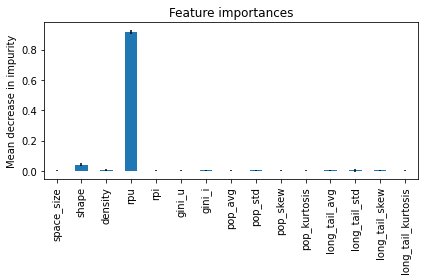

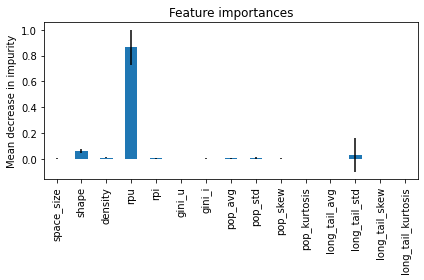

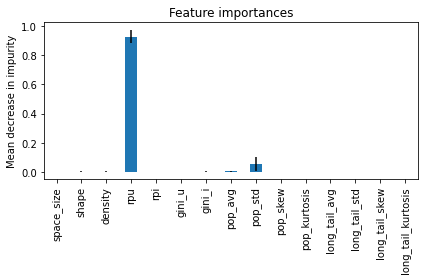

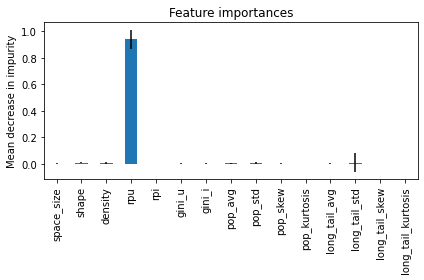

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

algos_2 = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]

df = feature_matrix()

for i, algo in enumerate(algos_2):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    forest = RandomForestRegressor()
    forest.fit(x,y)
    importances = forest.feature_importances_
    std = np.std([
        tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=features_str)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [18]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

algos_2 = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]

def divide_Y_into_groups(Y, num_groups):
    max_y, min_y = max(Y), min(Y)
    bucket_size = (max_y-min_y)/num_groups
    y_buckets = [[] for _ in range(num_groups+1)]
    res = []
    for i in Y:
        idx = int((i-min_y)//bucket_size)
        y_buckets[idx].append(i)
        res.append(idx)
    return res, y_buckets

df = feature_matrix()

for i, algo in enumerate(algos_2):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    forest = RandomForestClassifier()
    x, y = get_x_y_from_pandas(df, features_str, algo)
    y, y_buckets = divide_Y_into_groups(y, 5)
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=123)
    forest.fit(X_train, y_train)
    mean_acc = forest.score(X_test, y_test)
    
    # print metrics
    print(f'acc@{algo} -> buckets size:{[len(a) for a in y_buckets]}')
    print(f'acc@{algo} -> forest_mean_acc: {round(mean_acc, 3)}')
    print()

acc@UserKNN-Amplified -> buckets size:[403, 133, 37, 21, 4, 1]
acc@UserKNN-Amplified -> forest_mean_acc: 0.907

acc@ItemKNN-AdjustedCosine -> buckets size:[148, 328, 78, 33, 12, 0]
acc@ItemKNN-AdjustedCosine -> forest_mean_acc: 0.893

acc@BPR -> buckets size:[323, 148, 73, 36, 18, 1]
acc@BPR -> forest_mean_acc: 0.933

acc@NMF -> buckets size:[404, 119, 42, 25, 9, 0]
acc@NMF -> forest_mean_acc: 0.907



In [14]:
import operator

def get_better_classifier(df, features_str, algos):
    X, Y = [], []
    xs = [[] for _ in range(len(features_str))]
    
    for i, f in enumerate(features_str):
        xs[i] = df[[f]].to_numpy().flatten()
    
    ys = df[algos].to_numpy()
    for y in ys:
        max_index, max_value = max(enumerate(y), key=operator.itemgetter(1))
        Y.append(algos[max_index])
    
    for i in range(len(xs[0])):
        X.append([x[i] for x in xs])
    return np.array(X), np.array(Y)

0.825

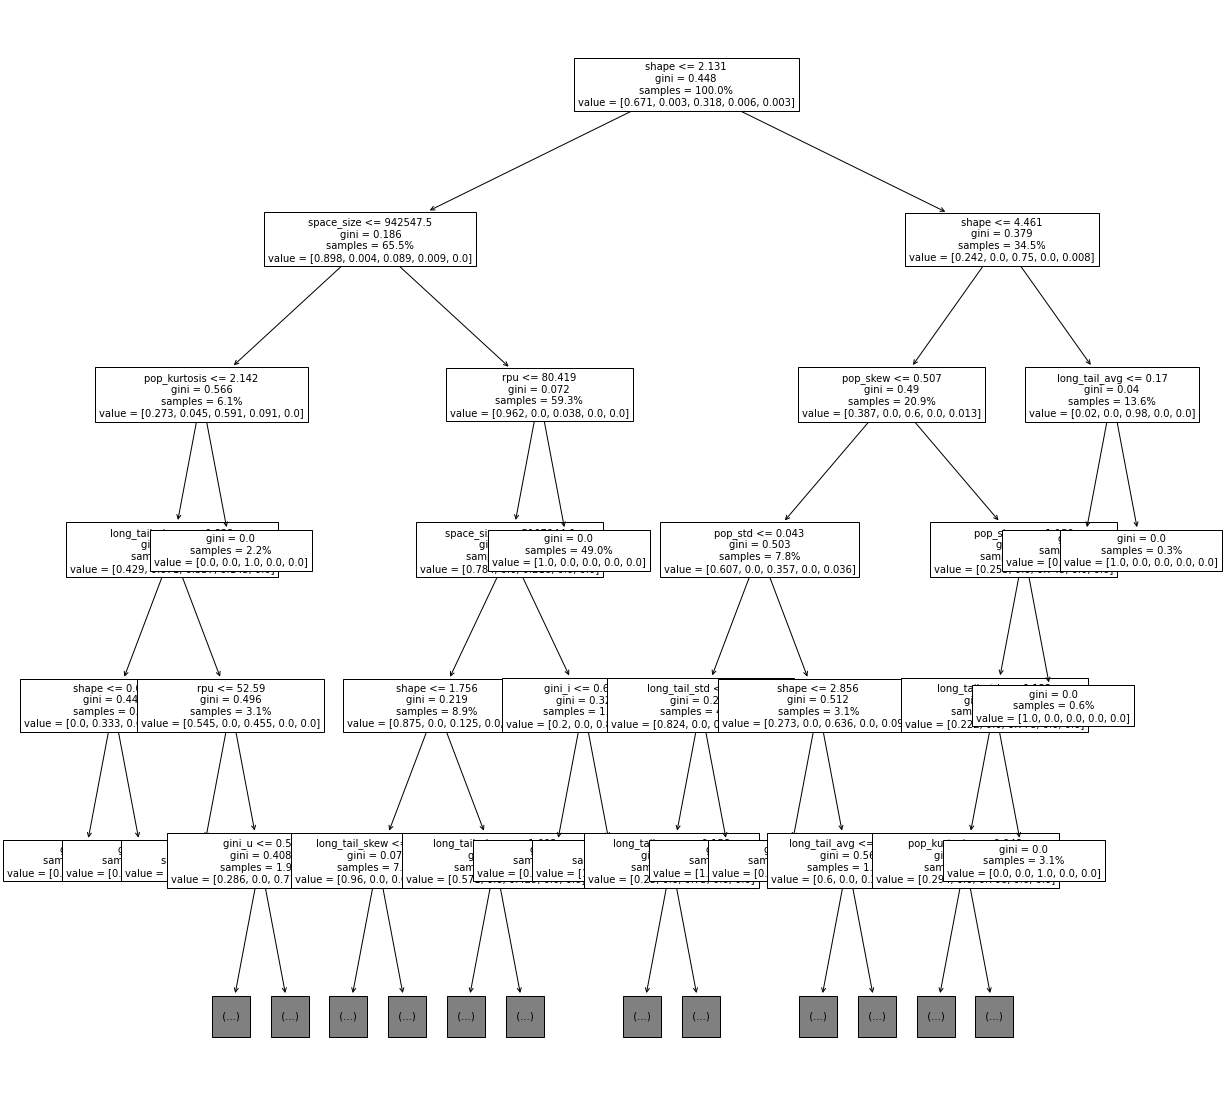

In [15]:
from sklearn.model_selection import train_test_split

X, y = get_better_classifier(df, features_str, algos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

plt.figure(figsize=(20,20))
tree.plot_tree(clf, max_depth=5, feature_names=features_str, proportion=True, fontsize=10)

clf.score(X_test, y_test)
